In [102]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import numpy as np
from sklearn.model_selection import train_test_split

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATASETS = {
    "sample_A": "/content/Housing.csv",
    "sample_B": "/content/advertising.csv",
    "sample_C": "/content/faa_ai_prelim.csv",
}

In [104]:
def load_features(csv_path, label_cols=None):
    p = Path(csv_path)
    df = pd.read_csv(p)

    if label_cols is not None:
        for col in label_cols:
            if col in df.columns:
                df = df.drop(columns=[col])
    df_num = df.select_dtypes(include=[np.number]).copy()
    df_num = df_num.loc[:, df_num.var(numeric_only=True) > 0]
    df_num = df_num.replace([np.inf, -np.inf], np.nan)
    df_num = df_num.fillna(df_num.mean(numeric_only=True))
    X = df_num.to_numpy(dtype=np.float64)
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

    return X, list(df_num.columns)

def eigenface_reconstruction_errors(X, n_list):
    mu = X.mean(axis=0, keepdims=True)
    A = X - mu
    n_samples, p = A.shape
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    evecs = Vt.T
    errors_sum, errors_per_sample = {}, {}
    for n in n_list:
        if n > p:
            continue
        E = evecs[:, :n]
        W = A @ E
        L = W @ E.T
        R = L + mu
        diff = X - R
        sse = float(np.sum(diff * diff))
        errors_sum[n] = sse
        errors_per_sample[n] = sse / n_samples
    return errors_sum, errors_per_sample, p

In [105]:
def run_for_datasets(datasets, n_list, label_columns_map=None):
    results_sum, results_avg, meta = {}, {}, {}
    for name, path in datasets.items():
        label_cols = None
        if label_columns_map and name in label_columns_map:
            label_cols = label_columns_map[name]
        X, cols = load_features(path, label_cols=label_cols)
        errors_sum, errors_avg, p = eigenface_reconstruction_errors(X, n_list)
        results_sum[name] = errors_sum
        results_avg[name] = errors_avg
        meta[name] = {"n_samples": X.shape[0], "n_features": p}
    return results_sum, results_avg, meta

In [106]:
def results_to_dataframe(results_dict):
    rows = []
    for dataset, d in results_dict.items():
        for n, val in d.items():
            rows.append({"dataset": dataset, "n": int(n), "value": float(val)})
    return pd.DataFrame(rows).sort_values(["dataset", "n"]).reset_index(drop=True)

sample_A: n_samples=545, n_features=6
sample_B: n_samples=200, n_features=4
sample_C: n_samples=83, n_features=4
dataset     sample_A    sample_B    sample_C
n                                           
1        1876.922663  389.993612  240.948646
2        1213.576668  141.212843  157.948649
3         844.534566   10.149534   74.948659
5         164.642026         NaN         NaN
dataset  sample_A  sample_B  sample_C
n                                    
1        3.443895  1.949968  2.902996
2        2.226746  0.706064  1.902996
3        1.549605  0.050748  0.902996
5        0.302095       NaN       NaN


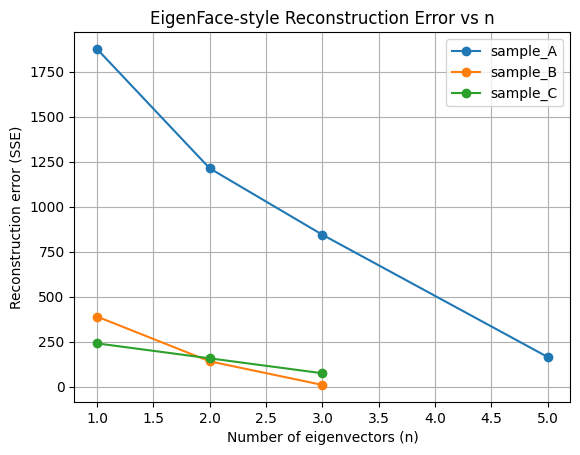

In [107]:
LABEL_COLUMNS = {}
N_EIGS_LIST = [1, 2, 3, 5, 7, 10, 15]
results_sum, results_avg, meta = run_for_datasets(DATASETS, N_EIGS_LIST, LABEL_COLUMNS)
df_sum = results_to_dataframe(results_sum)
df_avg = results_to_dataframe(results_avg)
for k, v in meta.items():
    print(f"{k}: n_samples={v['n_samples']}, n_features={v['n_features']}")
print(df_sum.pivot(index="n", columns="dataset", values="value"))
print(df_avg.pivot(index="n", columns="dataset", values="value"))

plt.figure()
for dataset in results_sum:
    ns = sorted(results_sum[dataset].keys())
    ys = [results_sum[dataset][n] for n in ns]
    plt.plot(ns, ys, marker="o", label=dataset)
plt.xlabel("Number of eigenvectors (n)")
plt.ylabel("Reconstruction error (SSE)")
plt.title("EigenFace-style Reconstruction Error vs n")
plt.legend()
plt.grid(True)
plt.show()

In [108]:
class SimpleLinearRegression:
    def __init__(self, epochs, learning_rate):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = 0

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).flatten()
        m, n_features = X.shape
        self.weights = np.zeros(n_features)
        for epoch in range(self.epochs):
            for i in range(m):
                xi = X[i, :]
                yi = y[i]
                y_pred = np.dot(xi, self.weights) + self.bias
                error = y_pred - yi
                gradient_w = xi * error
                gradient_b = error
                self.weights -= self.learning_rate * gradient_w
                self.bias -= self.learning_rate * gradient_b
    def predict(self, X):

        return np.dot(X, self.weights) + self.bias

In [109]:
class MomentumLinearRegression:
    def __init__(self, epochs=1000, learning_rate=0.001, gamma=0.9):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.weights = None
        self.bias = 0

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).flatten()
        m, n_features = X.shape
        self.weights = np.zeros(n_features)
        v_w = np.zeros(n_features)
        v_b = 0

        for epoch in range(self.epochs):
            for i in range(m):
                xi = X[i, :]
                yi = y[i]
                y_pred = np.dot(xi, self.weights) + self.bias
                error = y_pred - yi
                gradient_w = xi * error
                gradient_b = error

                v_w = self.gamma * v_w + self.learning_rate * gradient_w
                v_b = self.gamma * v_b + self.learning_rate * gradient_b

                self.weights -= v_w
                self.bias -= v_b

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


class NAGLinearRegression:
    def __init__(self, epochs=1000, learning_rate=0.001, gamma=0.9):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.weights = None
        self.bias = 0

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).flatten()
        m, n_features = X.shape
        self.weights = np.zeros(n_features)
        v_w = np.zeros(n_features)
        v_b = 0

        for epoch in range(self.epochs):
            for i in range(m):
                xi = X[i, :]
                yi = y[i]

                w_lookahead = self.weights - self.gamma * v_w
                b_lookahead = self.bias - self.gamma * v_b

                y_pred = np.dot(xi, w_lookahead) + b_lookahead
                error = y_pred - yi
                gradient_w = xi * error
                gradient_b = error

                v_w = self.gamma * v_w + self.learning_rate * gradient_w
                v_b = self.gamma * v_b + self.learning_rate * gradient_b

                self.weights -= v_w
                self.bias -= v_b

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [110]:
from sklearn.metrics import mean_squared_error

def train_and_track(model, X, y, X_val, y_val):
    X = np.array(X)
    y = np.array(y).flatten()
    losses = []

    m, n_features = X.shape
    model.weights = np.zeros(n_features)
    model.bias = 0

    v_w = np.zeros(n_features)
    v_b = 0

    for epoch in range(model.epochs):
        for i in range(m):
            xi = X[i, :]
            yi = y[i]

            if isinstance(model, NAGLinearRegression):
                w_lookahead = model.weights - model.gamma * v_w
                b_lookahead = model.bias - model.gamma * v_b
                y_pred = np.dot(xi, w_lookahead) + b_lookahead
            else:
                y_pred = np.dot(xi, model.weights) + model.bias

            error = y_pred - yi
            gradient_w = xi * error
            gradient_b = error

            if isinstance(model, SimpleLinearRegression):
                model.weights -= model.learning_rate * gradient_w
                model.bias -= model.learning_rate * gradient_b
            else:
                v_w = model.gamma * v_w + model.learning_rate * gradient_w
                v_b = model.gamma * v_b + model.learning_rate * gradient_b
                model.weights -= v_w
                model.bias -= v_b

        y_val_pred = model.predict(X_val)
        loss = mean_squared_error(y_val, y_val_pred)
        losses.append(loss)

    return losses


In [111]:
housing_df=pd.read_csv('Housing.csv')
numerical_data = housing_df.select_dtypes(include='number')
categorical_data = housing_df.select_dtypes(exclude='number')

encoded_df = pd.DataFrame(index=housing_df.index)
for col in categorical_data.columns:
    for val in categorical_data[col].unique():
        encoded_df[f"{col}_{val}"] = (categorical_data[col] == val).astype(int)

encoded_df = pd.concat([encoded_df, numerical_data], axis=1)
X = encoded_df.drop("price", axis=1)
y = encoded_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_cols = [col for col in numerical_data.columns if col != 'price']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_mean = X_train[num_cols].mean()
X_std = X_train[num_cols].std(ddof=0)
X_train_scaled[num_cols] = (X_train[num_cols] - X_mean) / X_std
X_test_scaled[num_cols] = (X_test[num_cols] - X_mean) / X_std
X_train_scaled = X_train_scaled.values
X_test_scaled = X_test_scaled.values
y_mean = y_train.mean()
y_std = y_train.std(ddof=0)
y_train_scaled = ((y_train - y_mean) / y_std).values.flatten()
y_test_scaled = ((y_test - y_mean) / y_std).values.flatten()

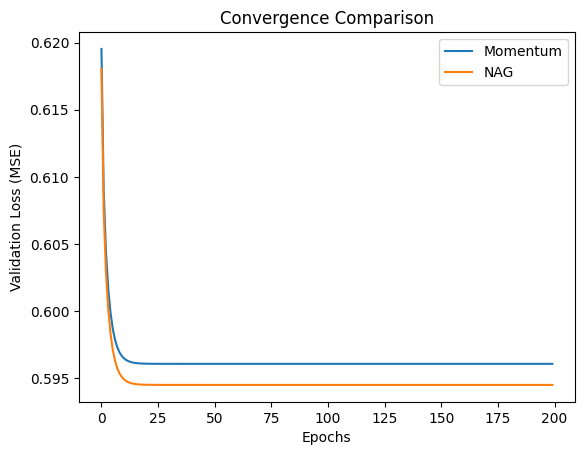

In [112]:
momentum = MomentumLinearRegression(epochs=200, learning_rate=0.001, gamma=0.9)
nag = NAGLinearRegression(epochs=200, learning_rate=0.001, gamma=0.9)

losses_momentum = train_and_track(momentum, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
losses_nag = train_and_track(nag, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

import matplotlib.pyplot as plt
plt.plot(losses_momentum, label="Momentum")
plt.plot(losses_nag, label="NAG")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (MSE)")
plt.legend()
plt.title("Convergence Comparison")
plt.show()

In [113]:
advertising_df=pd.read_csv('advertising.csv')
numerical_data = advertising_df.select_dtypes(include='number')
categorical_data = advertising_df.select_dtypes(exclude='number')

encoded_df = pd.DataFrame(index=advertising_df.index)
for col in categorical_data.columns:
    for val in categorical_data[col].unique():
        encoded_df[f"{col}_{val}"] = (categorical_data[col] == val).astype(int)

encoded_df = pd.concat([encoded_df, numerical_data], axis=1)
X = encoded_df.drop("Sales", axis=1)
y = encoded_df["Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_cols = [col for col in numerical_data.columns if col != 'Sales']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_mean = X_train[num_cols].mean()
X_std = X_train[num_cols].std(ddof=0)
X_train_scaled[num_cols] = (X_train[num_cols] - X_mean) / X_std
X_test_scaled[num_cols] = (X_test[num_cols] - X_mean) / X_std
X_train_scaled = X_train_scaled.values
X_test_scaled = X_test_scaled.values
y_mean = y_train.mean()
y_std = y_train.std(ddof=0)
y_train_scaled = ((y_train - y_mean) / y_std).values.flatten()
y_test_scaled = ((y_test - y_mean) / y_std).values.flatten()

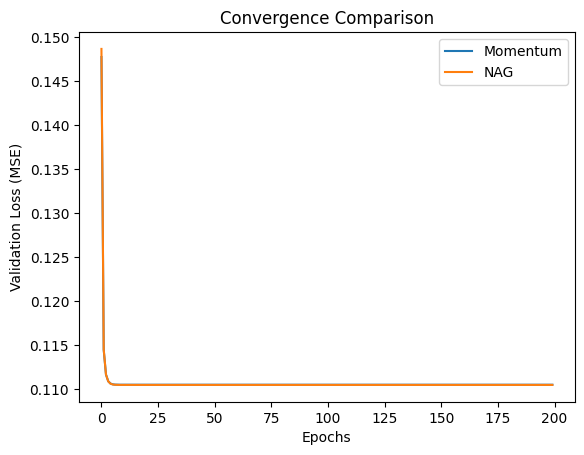

In [114]:
momentum = MomentumLinearRegression(epochs=200, learning_rate=0.001, gamma=0.9)
nag = NAGLinearRegression(epochs=200, learning_rate=0.001, gamma=0.9)

losses_momentum = train_and_track(momentum, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
losses_nag = train_and_track(nag, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

import matplotlib.pyplot as plt
plt.plot(losses_momentum, label="Momentum")
plt.plot(losses_nag, label="NAG")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (MSE)")
plt.legend()
plt.title("Convergence Comparison")
plt.show()